# Avito Challenge

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
train_df = pd.read_csv("E:/_Gen/Avito Competition/train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("E:/_Gen/Avito Competition/test.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)

Train file rows and columns are :  (1503424, 18)
Test file rows and columns are :  (508438, 17)


In [4]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [5]:
test_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



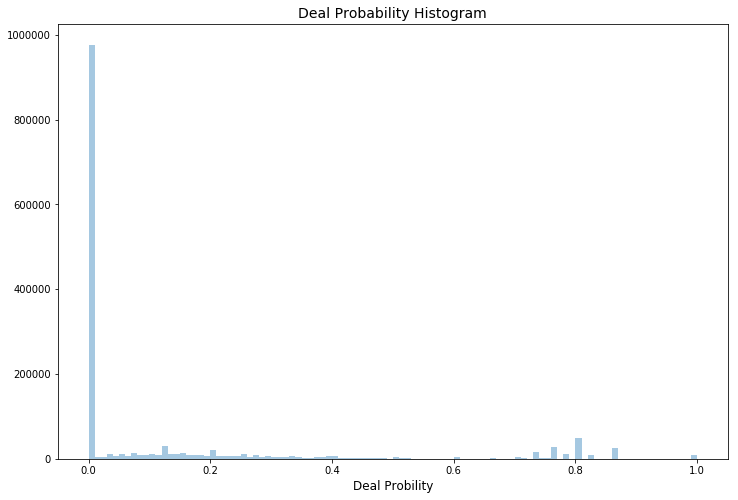

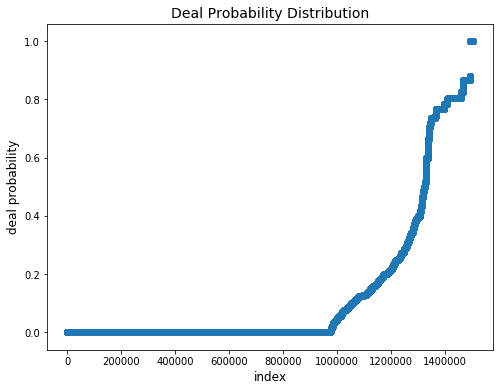

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

In [7]:
from io import StringIO

temp_data = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, region_df, how="left", on="region")

In [8]:
temp_series = train_df['region_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

In [9]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
full_tfidf = tfidf_vec.fit_transform(train_df['title'].values.tolist() + test_df['title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['title'].values.tolist())

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 576x576 with 0 Axes>

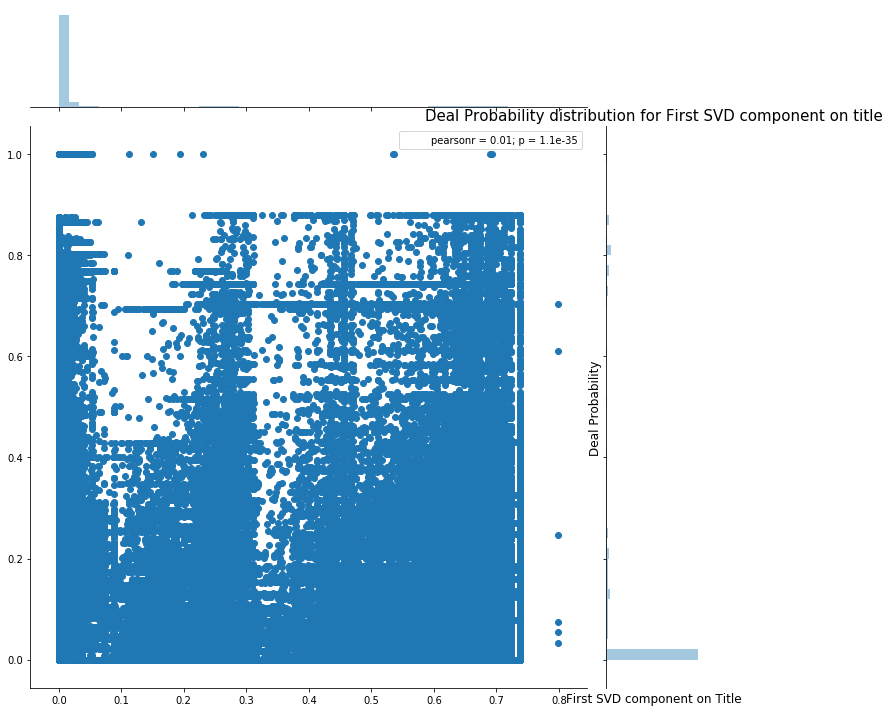

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 576x576 with 0 Axes>

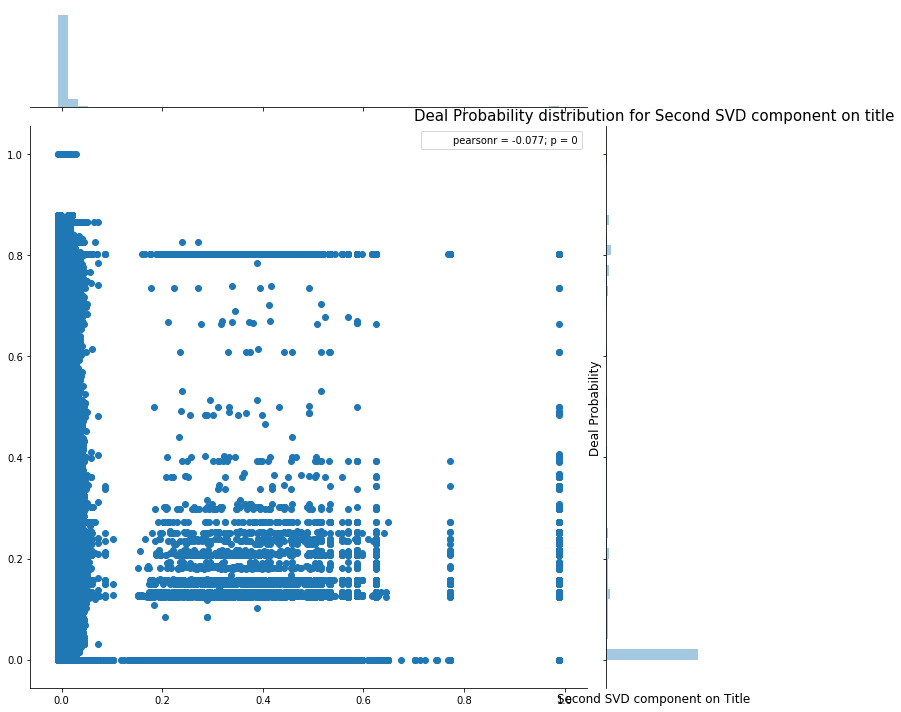

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 576x576 with 0 Axes>

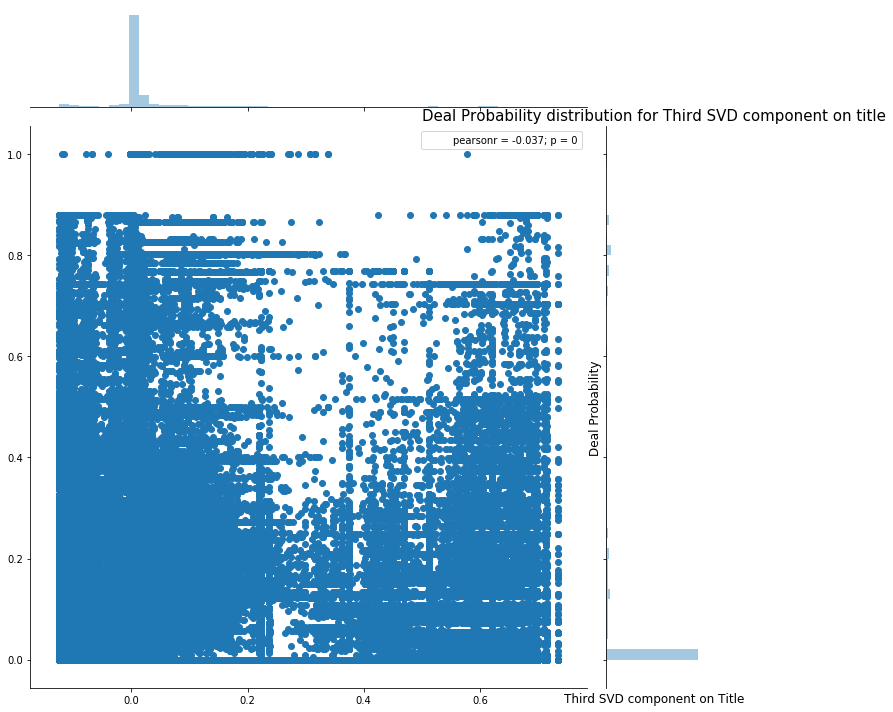

In [10]:
# 1st svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_1"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on title", fontsize=15)
plt.show()

# 2nd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_2"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

# 3rd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_3"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Third SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on title", fontsize=15)
plt.show()

In [11]:
## Filling missing values ##
train_df["description"].fillna("NA", inplace=True)
test_df["description"].fillna("NA", inplace=True)

train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))
test_df["desc_nwords"] = test_df["description"].apply(lambda x: len(x.split()))

cnt_srs = train_df['desc_nwords'].value_counts().head(100)

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in Description column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="desc_nwords")

In [12]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_features=100000)
full_tfidf = tfidf_vec.fit_transform(train_df['description'].values.tolist() + test_df['description'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['description'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['description'].values.tolist())

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 576x576 with 0 Axes>

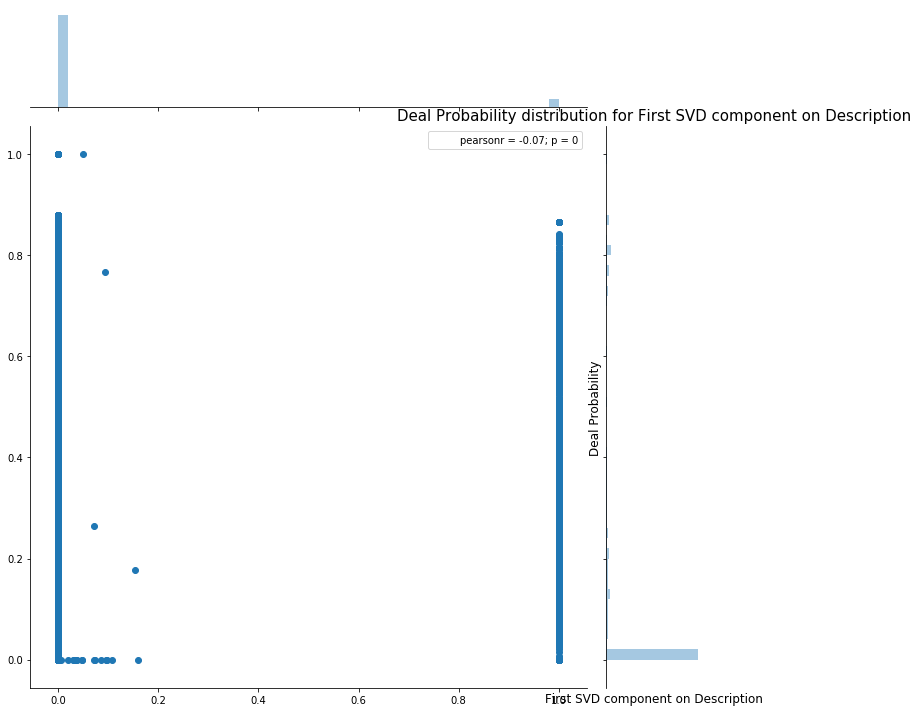

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 576x576 with 0 Axes>

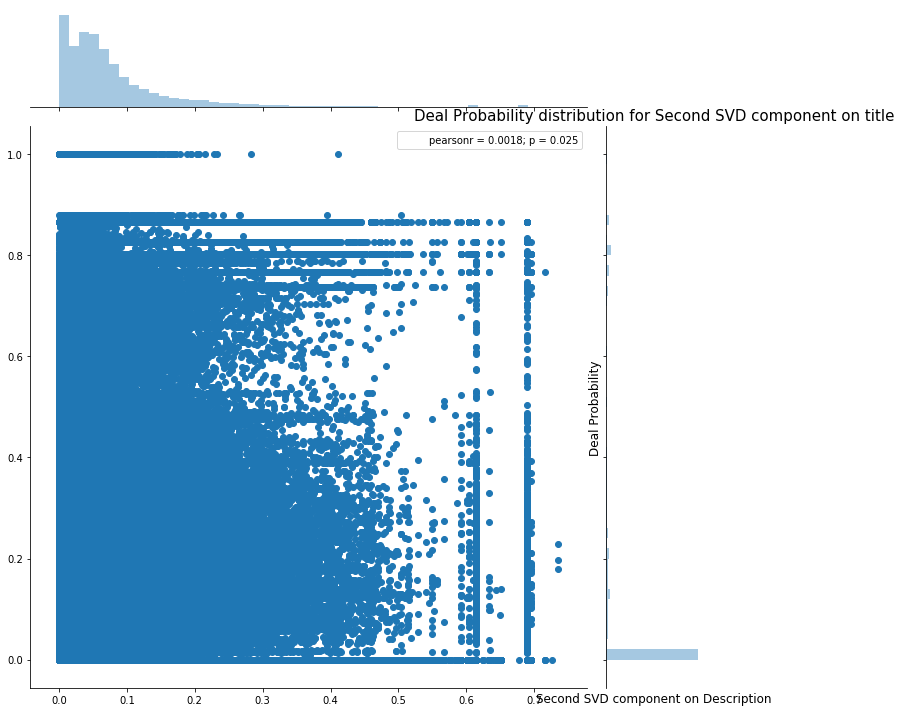

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 576x576 with 0 Axes>

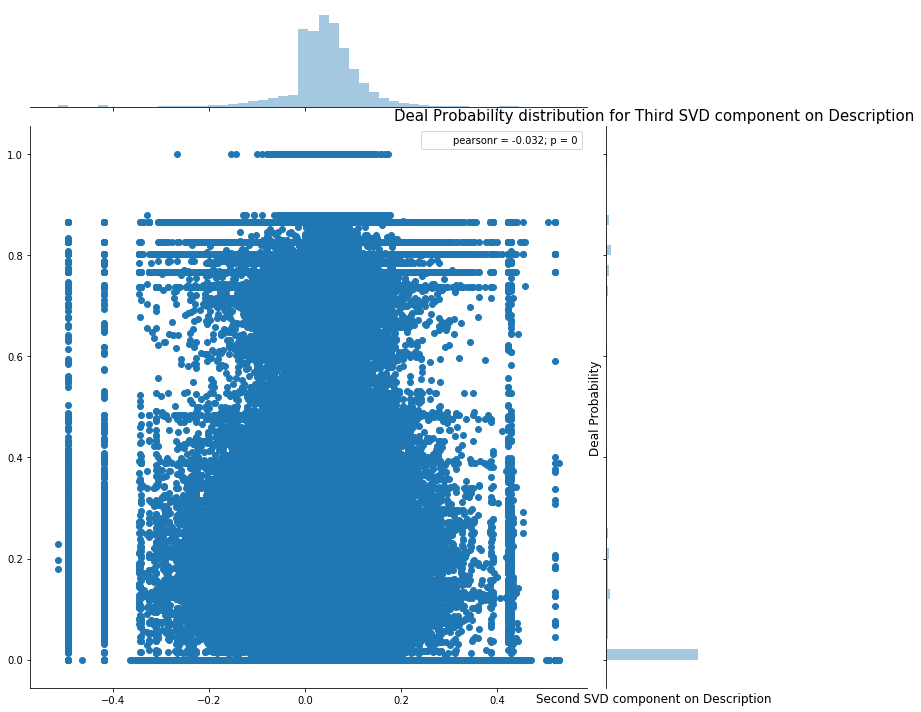

In [13]:
# 1st svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_1"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on Description", fontsize=15)
plt.show()

# 2nd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_2"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

# 3rd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_3"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on Description", fontsize=15)
plt.show()

In [15]:
# Target and ID variables #
train_y = train_df["deal_probability"].values
test_id = test_df["item_id"].values

# New variable on weekday #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
test_df["activation_weekday"] = test_df["activation_date"].dt.weekday

# Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image"]
train_X = train_df.drop(cols_to_drop + ["region_en", "deal_probability"], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [16]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [17]:
# Splitting the data for model training#
dev_X = train_X.iloc[:-200000,:]
val_X = train_X.iloc[-200000:,:]
dev_y = train_y[:-200000]
val_y = train_y[-200000:]
print(dev_X.shape, val_X.shape, test_X.shape)

# Training the model #
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

# Making a submission file #
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

(1303424, 19) (200000, 19) (508438, 19)
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.235886
[40]	valid_0's rmse: 0.232749
[60]	valid_0's rmse: 0.231346
[80]	valid_0's rmse: 0.230508
[100]	valid_0's rmse: 0.229953
[120]	valid_0's rmse: 0.229512
[140]	valid_0's rmse: 0.229172
[160]	valid_0's rmse: 0.228852
[180]	valid_0's rmse: 0.228617
[200]	valid_0's rmse: 0.2284
[220]	valid_0's rmse: 0.22825
[240]	valid_0's rmse: 0.228069
[260]	valid_0's rmse: 0.227933
[280]	valid_0's rmse: 0.227798
[300]	valid_0's rmse: 0.227647
[320]	valid_0's rmse: 0.227549
[340]	valid_0's rmse: 0.227415
[360]	valid_0's rmse: 0.227312
[380]	valid_0's rmse: 0.227235
[400]	valid_0's rmse: 0.227146
[420]	valid_0's rmse: 0.227061
[440]	valid_0's rmse: 0.22697
[460]	valid_0's rmse: 0.226882
[480]	valid_0's rmse: 0.226814
[500]	valid_0's rmse: 0.226768
[520]	valid_0's rmse: 0.226731
[540]	valid_0's rmse: 0.226674
[560]	valid_0's rmse: 0.226615
[580]	valid_0's rmse: 0.226544
[600]	

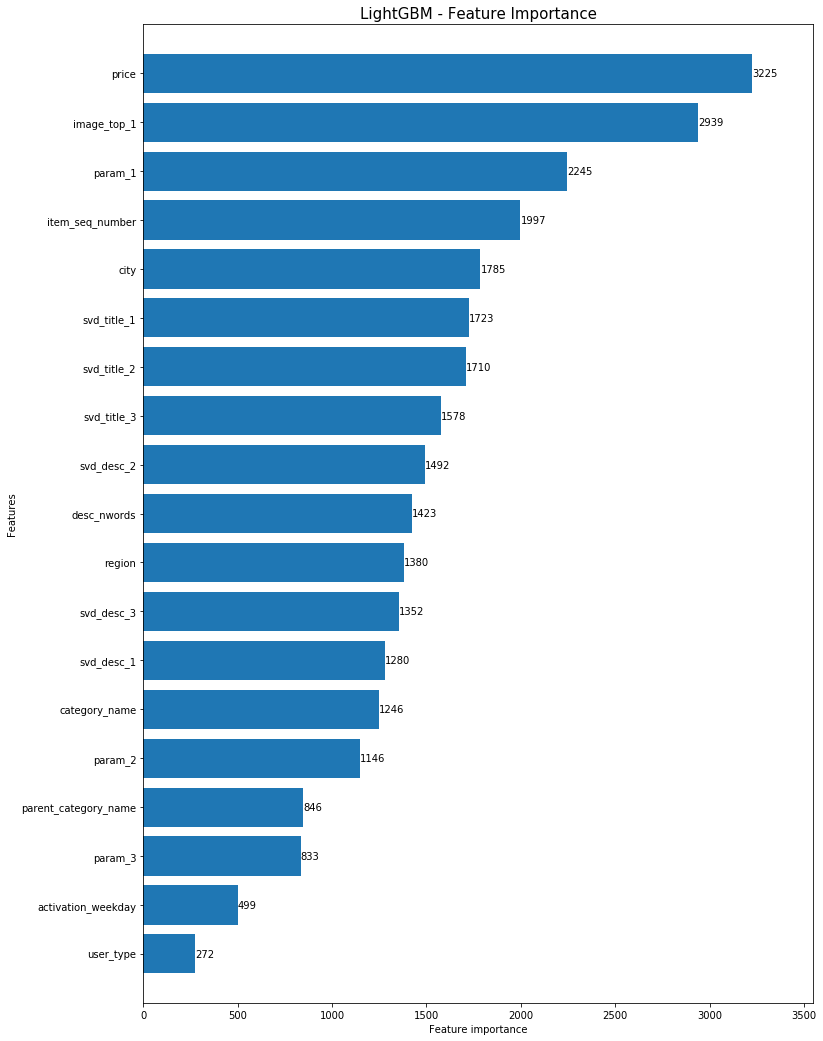

In [18]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()